In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import argparse
import skimage.transform
from tensorboardX import SummaryWriter
import random
import os
import os.path
import matplotlib.image as mpimg
from PIL import Image
import import_ipynb
from MonodepthModel_adapt import *
import scipy.misc
import scipy.io as sio
import cv2
from Discriminator import *
from IPython.display import clear_output
from flow_warp.Optical_Flow_Warping_Tensorflow.flownet2_pytorch.networks.submodules import *
from flow_warp.Optical_Flow_Warping_Tensorflow.flownet2_pytorch.networks.resample2d_package.modules.resample2d import Resample2d
os.environ['TF_CPP_MIN_LOG_LEVEL']='1'

torch.cuda.set_device(0)

In [50]:
def get_args():
    parser = argparse.ArgumentParser(description='Monodepth PyTorch implementation.')
    
    parser.add_argument('--mode',                      type=str,   help='train or test', default='train')
    parser.add_argument('--model_name',                type=str,   help='model name', default='monodepth')
    parser.add_argument('--encoder',                   type=str,   help='type of encoder, vgg or resnet50', default='vgg')
    parser.add_argument('--dataset',                   type=str,   help='dataset to train on, kitti, or cityscapes', default='kitti')
    parser.add_argument('--data_path',                 type=str,   help='path to the data', required=True)
    parser.add_argument('--filenames_file',            type=str,   help='path to the filenames text file', required=True)
    parser.add_argument('--input_height',              type=int,   help='input height', default=256)
    parser.add_argument('--input_width',               type=int,   help='input width', default=512)
    parser.add_argument('--batch_size',                type=int,   help='batch size', default=8)
    parser.add_argument('--num_epochs',                type=int,   help='number of epochs', default=50)
    parser.add_argument('--learning_rate',             type=float, help='initial learning rate', default=1e-4)
    parser.add_argument('--lr_loss_weight',            type=float, help='left-right consistency weight', default=1.0)
    parser.add_argument('--alpha_image_loss',          type=float, help='weight between SSIM and L1 in the image loss', default=0.85)
    parser.add_argument('--disp_gradient_loss_weight', type=float, help='disparity smoothness weigth', default=0.1)
    parser.add_argument('--do_stereo',                             help='if set, will train the stereo model', action='store_true')
    parser.add_argument('--wrap_mode',                 type=str,   help='bilinear sampler wrap mode, edge or border', default='border')
    parser.add_argument('--use_deconv',                            help='if set, will use transposed convolutions', action='store_true')
    parser.add_argument('--num_gpus',                  type=int,   help='number of GPUs to use for training', default=1)
    parser.add_argument('--num_threads',               type=int,   help='number of threads to use for data loading', default=8)
    parser.add_argument('--output_directory',          type=str,   help='output directory for test disparities, if empty outputs to checkpoint folder', default='')
    parser.add_argument('--log_directory',             type=str,   help='directory to save checkpoints and summaries', default='')
    parser.add_argument('--checkpoint_path',           type=str,   help='path to a specific checkpoint to load', default='')
    parser.add_argument('--retrain',                               help='if used with checkpoint_path, will restart training from step zero', action='store_true')
    parser.add_argument('--full_summary',                          help='if set, will keep more data for each summary. Warning: the file can become very large', action='store_true')
    
    args = parser.parse_args()
    return args


In [51]:
#args = get_args()
net = MonodepthNet().cuda()
D = FCDiscriminator(2048).cuda()
#net = torch.load("/home/hylai/monodepth/model_city2kitti")
#net = torch.load("/eva_data/hylai_model/kitti_flow_supervised_syn_44/model_epoch35")
optimizer = optim.Adam(net.parameters(), lr=1e-4)
params = list(net.parameters())
name = list(net.named_parameters())

In [52]:
def get_data(path = '/eva_data/hylai_model/my/output/folder/'):
    #path2 = '/eva_data/hylai_model/dataset/kitti2/'
    file_path_train = '/home/hylai/monodepth/utils/filenames/kitti_train_files.txt'
    file_path_test = '/home/hylai/monodepth/utils/filenames/eigen_test_files.txt'
    #file_path_flow_train = '/home/hylai/monodepth/utils/filenames/kitti_total_flow_train_files.txt'
    f_train = open(file_path_train)
    f_test = open(file_path_test)
    #f_flow_train = open(file_path_flow_train)
    left_image_train = list()
    right_image_train = list()
    left_image_test = list()
    right_image_test = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        left_image_train.append(path+line.split()[0])
        right_image_train.append(path+line.split()[1])
    for line in f_test:
        num_test += 1
        left_image_test.append(path+line.split()[0])
        right_image_test.append(path+line.split()[1])
        
    return left_image_train, right_image_train, left_image_test, right_image_test, num_train, num_test

In [53]:
def get_cs_data(path_right = '/eva_data/hylai_model/dataset/cityscape/rightImg8bit/train_extra/'):
    path_left = '/eva_data/hylai_model/dataset/cityscape/leftImg8bit/train_extra/'
    file_path_train = '/home/hylai/monodepth/utils/filenames/cityscapes_train_files.txt'
    file_path_test = '/home/hylai/monodepth/utils/filenames/cityscapes_test_files.txt'
    f_train = open(file_path_train)
    f_test = open(file_path_test)
    left_image_train = list()
    right_image_train = list()
    left_image_test = list()
    right_image_test = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        left_image_train.append(path_left+line.split()[0])
        right_image_train.append(path_right+line.split()[1])
    for line in f_test:
        num_test += 1
        left_image_test.append(path_left+line.split()[0])
        right_image_test.append(path_right+line.split()[1])
        
    return left_image_train, right_image_train, left_image_test, right_image_test, num_train, num_test

In [54]:
def get_flow_data(path = '/eva_data/hylai_model/dataset/kitti2/'):
    path2 = '/eva_data/hylai_model/dataset/kitti/'
    file_path_train = '/home/hylai/monodepth/utils/filenames/kitti_total_flow_train_files.txt'
    file_path_test = '/home/hylai/monodepth/utils/filenames/kitti_flow_test_files.txt'
    f_train = open(file_path_train)
    f_test = open(file_path_test)
    former_image_train = list()
    latter_image_train = list()
    #flow_train = list()
    former_image_test = list()
    latter_image_test = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        former_image_train.append(path+line.split()[0])
        latter_image_train.append(path+line.split()[1])
        #flow_train.append(path+line.split()[2])
    for line in f_test:
        num_test += 1
        former_image_test.append(path+line.split()[0])
        latter_image_test.append(path+line.split()[1])
        
    return former_image_train, latter_image_train, former_image_test, latter_image_test

In [55]:
def get_play_data(path = '/eva_data/hylai_model/dataset/play_for_benchmark/'):
    #path2 = '/eva_data/hylai_model/dataset/kitti/'
    file_path_train = '/eva_data/hylai_model/dataset/play_for_benchmark/flow_train.txt'
    #file_path_test = '/home/hylai/monodepth/utils/filenames/kitti_flow_test_files.txt'
    f_train = open(file_path_train)
    former_image_train = list()
    latter_image_train = list()
    flow_train = list()
    
    num_train = 0
    num_test = 0
    
    for line in f_train:
        num_train += 1
        former_image_train.append(path+line.split()[0])
        latter_image_train.append(path+line.split()[1])
        flow_train.append(path+line.split()[2])
    """
    for line in f_test:
        num_test += 1
        former_image_test.append(path+line.split()[0])
        latter_image_test.append(path+line.split()[1])
    """
        
    return former_image_train, latter_image_train, flow_train
"""
import os, os.path
from random import randint
a = [0]
for i in range(1, 78):
    path = '/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/'+"%03d"%i
    f = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    path = '/eva_data/hylai_model/dataset/play_for_benchmark/train/img/'+"%03d"%i
    i = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    a.append(i)
print(a)

count = 0
wtf = 0
wtf2 = 0
while 1:
    random_dir = randint(1, 77)
    random_file = randint(1, a[random_dir]-1)
    if not os.path.isfile('/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.mat'):
        wtf += 1
        continue
    print(random_dir, random_file)
    k = sio.loadmat('/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.mat')
    print(random_dir, random_file)
    if 'u' not in k or 'v' not in k:
        wtf2 += 1
        print("???")
        continue
    with open('/eva_data/hylai_model/dataset/play_for_benchmark/flow_train.txt', 'a') as f:
        f.write('train/img/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.png ')
        f.write('train/img/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%(random_file+1)+'.png ')
        f.write('train/flow/'+"%03d"%random_dir+'/'+"%03d"%random_dir+'_'+"%05d"%random_file+'.mat\n')
        count += 1
    clear_output()
    if count == 1081:
        break
print(count, wtf, wtf2)
"""

'\nimport os, os.path\nfrom random import randint\na = [0]\nfor i in range(1, 78):\n    path = \'/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/\'+"%03d"%i\n    f = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])\n    path = \'/eva_data/hylai_model/dataset/play_for_benchmark/train/img/\'+"%03d"%i\n    i = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])\n    a.append(i)\nprint(a)\n\ncount = 0\nwtf = 0\nwtf2 = 0\nwhile 1:\n    random_dir = randint(1, 77)\n    random_file = randint(1, a[random_dir]-1)\n    if not os.path.isfile(\'/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/\'+"%03d"%random_dir+\'/\'+"%03d"%random_dir+\'_\'+"%05d"%random_file+\'.mat\'):\n        wtf += 1\n        continue\n    print(random_dir, random_file)\n    k = sio.loadmat(\'/eva_data/hylai_model/dataset/play_for_benchmark/train/flow/\'+"%03d"%random_dir+\'/\'+"%03d"%random_dir+\'_\'+"%05d"%random_file+\'.mat\')\n   

In [56]:
def get_transform():
    return transforms.Compose([
        transforms.Scale([512, 256]),
        transforms.ToTensor()
    ])

In [57]:
class myImageFolder(data.Dataset):
    def __init__(self, left, right, training, flow = None):
        self.right = right
        self.left = left
        self.training = training
        self.flow = flow
        
    def __getitem__(self, index):
        left = self.left[index]
        right = self.right[index]
        left_image = Image.open(left).convert('RGB')
        right_image = Image.open(right).convert('RGB')
        
        if self.flow is not None:
            flow = self.flow[index]
            #flow_image = Image.open(flow).convert('RGB')
            d = sio.loadmat(flow)
            flow_image = np.concatenate((np.expand_dims(d['u'], 2), np.expand_dims(d['v'], 2)), axis = 2)
            where_are_nan = np.isnan(flow_image)
            flow_image[where_are_nan] = 0
        
        #augmentation
        if self.training:
            
            #randomly flip
            if random.uniform(0, 1) > 0.5 and self.flow is None:
                left_image = left_image.transpose(Image.FLIP_LEFT_RIGHT)
                right_image = right_image.transpose(Image.FLIP_LEFT_RIGHT)
                if self.flow is not None:
                    flow_image = flow_image.transpose(Image.FLIP_LEFT_RIGHT)
                
            #randomly shift gamma
            if random.uniform(0, 1) > 0.5:
                gamma = random.uniform(0.8, 1.2)
                left_image = Image.fromarray(np.clip((np.array(left_image) ** gamma), 0, 255).astype('uint8'), 'RGB')
                right_image = Image.fromarray(np.clip((np.array(right_image) ** gamma), 0, 255).astype('uint8'), 'RGB')
            
            #randomly shift brightness
            if random.uniform(0, 1) > 0.5:
                brightness = random.uniform(0.5, 2.0)
                left_image = Image.fromarray(np.clip((np.array(left_image) * brightness), 0, 255).astype('uint8'), 'RGB')
                right_image = Image.fromarray(np.clip((np.array(right_image) * brightness), 0, 255).astype('uint8'), 'RGB')
            
            #randomly shift color
            if random.uniform(0, 1) > 0.5:
                colors = [random.uniform(0.8, 1.2) for i in range(3)]
                shape = np.array(left_image).shape
                white = np.ones((shape[0], shape[1]))
                color_image = np.stack([white * colors[i] for i in range(3)], axis=2)
                left_image = Image.fromarray(np.clip((np.array(left_image) * color_image), 0, 255).astype('uint8'), 'RGB')
                right_image = Image.fromarray(np.clip((np.array(right_image) * color_image), 0, 255).astype('uint8'), 'RGB')
                
        
        #transforms
        process = get_transform()
        left_image = process(left_image)
        right_image = process(right_image)
        
        if self.flow is not None:
            flow_image = cv2.resize(flow_image, (512,256))
            flow_image = np.transpose(flow_image, [2,0,1])
            #flow_image[0,:,:] = - (flow_image[0,:,:] - 0.5) * flow_image.shape[2]
            #flow_image[1,:,:] = (flow_image[1,:,:] - 0.5) * flow_image.shape[1]
            flow_image[0,:,:] = flow_image[0,:,:] * flow_image.shape[2] / 1920
            flow_image[1,:,:] = flow_image[1,:,:] * flow_image.shape[1] / 1080
            return left_image, right_image, torch.FloatTensor(flow_image)
        
        return left_image, right_image
    def __len__(self):
        return len(self.left)

In [58]:
def make_pyramid(image, num_scales):
    scale_image = [Variable(image.cuda())]
    height, width = image.shape[2:]

    for i in range(num_scales - 1):
        new = []
        for j in range(image.shape[0]):
            ratio = 2 ** (i+1)
            nh = height // ratio
            nw = width // ratio
            tmp = transforms.ToPILImage()(image[j]).convert('RGB')
            tmp = transforms.Scale([nw, nh])(tmp)
            tmp = transforms.ToTensor()(tmp)
            new.append(tmp.unsqueeze(0))
        this = torch.cat((i for i in new), 0)
        scale_image.append(Variable(this.cuda()))
        
    return scale_image

In [59]:
def gradient_x(img):
    gx = torch.add(img[:,:,:-1,:], -1, img[:,:,1:,:])
    return gx

def gradient_y(img):
    gy = torch.add(img[:,:,:,:-1], -1, img[:,:,:,1:])
    return gy

def get_disparity_smoothness(disp, pyramid):
    disp_gradients_x = [gradient_x(d) for d in disp]
    disp_gradients_y = [gradient_y(d) for d in disp]

    image_gradients_x = [gradient_x(img) for img in pyramid]
    image_gradients_y = [gradient_y(img) for img in pyramid]
    
    weights_x = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradients_x]
    weights_y = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradients_y]
    
    smoothness_x = [disp_gradients_x[i] * weights_x[i] for i in range(4)]
    smoothness_y = [disp_gradients_y[i] * weights_y[i] for i in range(4)]
    
    return smoothness_x + smoothness_y

In [60]:
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    mu_x = F.avg_pool2d(x, 3, 1, 0)
    mu_y = F.avg_pool2d(y, 3, 1, 0)
    
    #(input, kernel, stride, padding)
    sigma_x  = F.avg_pool2d(x ** 2, 3, 1, 0) - mu_x ** 2
    sigma_y  = F.avg_pool2d(y ** 2, 3, 1, 0) - mu_y ** 2
    sigma_xy = F.avg_pool2d(x * y , 3, 1, 0) - mu_x * mu_y
    
    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    
    SSIM = SSIM_n / SSIM_d
    
    return torch.clamp((1 - SSIM) / 2, 0, 1)

In [61]:
def post_process_disparity(disp):
    _, h, w = disp.shape
    l_disp = -disp[0,:,:]
    r_disp = np.fliplr(disp[1,:,:])
    m_disp = 0.5 * (l_disp + r_disp)
    l, _ = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp

In [62]:
left_image_train, right_image_train, left_image_test, right_image_test, num_train, num_test = get_data()
TrainImageLoader = torch.utils.data.DataLoader(
         myImageFolder(left_image_train, right_image_train, True), 
         batch_size = 4, shuffle = True, num_workers = 8, drop_last =False)
TestImageLoader = torch.utils.data.DataLoader(
         myImageFolder(left_image_test, right_image_test, False),
         batch_size = 1, shuffle = False, num_workers = 1, drop_last =False)

former_train, latter_train, former_test, latter_test = get_flow_data()
TrainFlowLoader = torch.utils.data.DataLoader(
         myImageFolder(former_train, latter_train, True), 
         batch_size = 4, shuffle = True, num_workers = 8, drop_last =False)
TestFlowLoader = torch.utils.data.DataLoader(
         myImageFolder(former_test, latter_test, False),
         batch_size = 8, shuffle = False, num_workers = 8, drop_last =False)

former_syn_train, latter_syn_train, flow_syn_train = get_play_data()
TrainSynFlowLoader = torch.utils.data.DataLoader(
         myImageFolder(former_syn_train, latter_syn_train, True, flow_syn_train), 
         batch_size = 4, shuffle = False, num_workers = 8, drop_last =False)

#Train
do_stereo = 1
alpha_image_loss = 0.85
disp_gradient_loss_weight = 0.1
lr_loss_weight = 1.0
num_epochs = 50
optimizer = optim.Adam(net.parameters(), lr = 0.0001)
optimizer_D = optim.Adam(D.parameters(), lr = 0.0001, betas=(0.9, 0.99))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[np.int32((3/5) * num_epochs), np.int32((4/5) * num_epochs)], gamma=0.5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_D, milestones=[np.int32((3/5) * num_epochs), np.int32((4/5) * num_epochs)], gamma=0.5)
loss = nn.L1Loss()
bce_loss = torch.nn.BCEWithLogitsLoss()
writer = SummaryWriter()

real = 1
fake = 0
"""
for batch_idx, (left, right, flow) in enumerate(TrainSynFlowLoader, 0):
    print(left.shape, right.shape, flow.shape)
    plt.imshow(flow[0,0,:,:])
    print(flow[0,0,:,:].min())
    break
"""

'\nfor batch_idx, (left, right, flow) in enumerate(TrainSynFlowLoader, 0):\n    print(left.shape, right.shape, flow.shape)\n    plt.imshow(flow[0,0,:,:])\n    print(flow[0,0,:,:].min())\n    break\n'

In [63]:
count = 0
real_adv_loss = 0
fake_adv_loss = 0
real_loss = 0
fake_loss = 0
dis_loss = 0

In [ ]:
for epoch in range(1, 51):
    scheduler.step()
    for batch_idx, ((left, right), (former, latter, gt)) in enumerate(zip(TrainImageLoader, TrainSynFlowLoader), 0):
        print(epoch, batch_idx)

        optimizer.zero_grad()
        optimizer_D.zero_grad()
        #generate image pyramid[scale][batch]
        left_pyramid = make_pyramid(left, 4)
        right_pyramid = make_pyramid(right, 4)
        
        if do_stereo:
            model_input = Variable(torch.cat((left, right), 1).cuda())
        else:
            model_input = Variable(left.cuda())
        
        disp_est_scale, disp_est, conv5_real = net(model_input)
        left_est = [Resample2d()(right_pyramid[i], disp_est_scale[i]) for i in range(4)]

        disp_left_smoothness = get_disparity_smoothness(disp_est, left_pyramid)
        l1_left = [torch.abs(left_est[i] - left_pyramid[i]) for i in range(4)]
        l1_reconstruction_loss_left = [torch.mean(l) for l in l1_left]
        ssim_left = [SSIM(left_est[i], left_pyramid[i]) for i in range(4)]
        ssim_loss_left = [torch.mean(s) for s in ssim_left]
        image_loss_left  = [alpha_image_loss * ssim_loss_left[i]  + (1 - alpha_image_loss) * l1_reconstruction_loss_left[i]  for i in range(4)]
        image_loss = image_loss_left[0] + image_loss_left[1] + image_loss_left[2] + image_loss_left[3]
        disp_left_loss  = [torch.mean(torch.abs(disp_left_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss = disp_left_loss[0] + disp_left_loss[1] + disp_left_loss[2] + disp_left_loss[3]
        
        D_out1 = D(F.softmax(conv5_real))
        total_loss = image_loss + disp_gradient_loss_weight * disp_gradient_loss# + lr_loss_weight * lr_loss
        

        model_input_2 = Variable(torch.cat((right, left), 1).cuda())
        disp_est_scale_2, disp_est_2, conv5_real_2 = net(model_input_2)
        right_est = [Resample2d()(left_pyramid[i], disp_est_scale_2[i]) for i in range(4)]

        disp_right_smoothness = get_disparity_smoothness(disp_est_2, right_pyramid)
        l1_right = [torch.abs(right_est[i] - right_pyramid[i]) for i in range(4)]
        l1_reconstruction_loss_right = [torch.mean(l) for l in l1_right]
        ssim_right = [SSIM(right_est[i], right_pyramid[i]) for i in range(4)]
        ssim_loss_right = [torch.mean(s) for s in ssim_right]
        image_loss_right  = [alpha_image_loss * ssim_loss_right[i]  + (1 - alpha_image_loss) * l1_reconstruction_loss_right[i]  for i in range(4)]
        image_loss_2 = image_loss_right[0] + image_loss_right[1] + image_loss_right[2] + image_loss_right[3]
        disp_right_loss  = [torch.mean(torch.abs(disp_right_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss_2 = disp_right_loss[0] + disp_right_loss[1] + disp_right_loss[2] + disp_right_loss[3]
        
        #LR consistency
        right_to_left_disp = [- Resample2d()(disp_est_2[i], disp_est_scale[i]) for i in range(4)]
        left_to_right_disp = [- Resample2d()(disp_est[i], disp_est_scale_2[i]) for i in range(4)]
        
        #LR consistency
        lr_left_loss  = [torch.mean(torch.abs(right_to_left_disp[i] - disp_est[i]))  for i in range(4)]
        lr_right_loss = [torch.mean(torch.abs(left_to_right_disp[i] - disp_est_2[i])) for i in range(4)]
        lr_loss = sum(lr_left_loss + lr_right_loss)
        
        #Total loss
        D_out2 = D(F.softmax(conv5_real_2))
        loss_D1 = bce_loss(D_out1, Variable(torch.FloatTensor(D_out1.data.size()).fill_(fake)).cuda())
        loss_D2 = bce_loss(D_out2, Variable(torch.FloatTensor(D_out2.data.size()).fill_(fake)).cuda())
        total_loss_2 = image_loss_2 + disp_gradient_loss_weight * disp_gradient_loss_2# + lr_loss_weight * lr_loss
        total = total_loss_2 + total_loss + lr_loss_weight * lr_loss + 0.001 *(loss_D1 + loss_D2)
        real_loss += 0.01 * total
        real_adv_loss += 0.01 * 0.001 * (loss_D1 + loss_D2)
        print(total)
        total.backward()

        #generate image pyramid[scale][batch]
        #left, right, gt = next(iter(TrainSynFlowLoader))

        left_pyramid = make_pyramid(former, 4)
        right_pyramid = make_pyramid(latter, 4)

        if do_stereo:
            model_input = Variable(torch.cat((former, latter), 1).cuda())
        else:
            model_input = Variable(former.cuda())
        
        disp_est_scale, disp_est, conv5_fake = net(model_input)
        left_est = [Resample2d()(right_pyramid[i], disp_est_scale[i]) for i in range(4)]

        disp_left_smoothness = get_disparity_smoothness(disp_est, left_pyramid)
        image_loss = loss(disp_est_scale[0], Variable(gt.cuda()))
        disp_left_loss  = [torch.mean(torch.abs(disp_left_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss = disp_left_loss[0] + disp_left_loss[1] + disp_left_loss[2] + disp_left_loss[3]
        
        D_out1 = D(F.softmax(conv5_fake))
        total_loss = image_loss + disp_gradient_loss_weight * disp_gradient_loss# + lr_loss_weight * lr_loss
        

        model_input_2 = Variable(torch.cat((latter, former), 1).cuda())
        disp_est_scale_2, disp_est_2, conv5_fake_2 = net(model_input_2)
        
        right_est = [Resample2d()(left_pyramid[i], disp_est_scale_2[i]) for i in range(4)]

        disp_right_smoothness = get_disparity_smoothness(disp_est_2, right_pyramid)
        disp_right_loss  = [torch.mean(torch.abs(disp_right_smoothness[i]))  / 2 ** i for i in range(4)]
        disp_gradient_loss_2 = disp_right_loss[0] + disp_right_loss[1] + disp_right_loss[2] + disp_right_loss[3]
        
        #LR consistency
        right_to_left_disp = [- Resample2d()(disp_est_2[i], disp_est_scale[i]) for i in range(4)]
        left_to_right_disp = [- Resample2d()(disp_est[i], disp_est_scale_2[i]) for i in range(4)]
        
        #LR consistency
        lr_left_loss  = [torch.mean(torch.abs(right_to_left_disp[i] - disp_est[i]))  for i in range(4)]
        lr_right_loss = [torch.mean(torch.abs(left_to_right_disp[i] - disp_est_2[i])) for i in range(4)]
        lr_loss = sum(lr_left_loss + lr_right_loss)
        
        #Total loss
        D_out2 = D(F.softmax(conv5_fake_2))
        loss_D1 = bce_loss(D_out1, Variable(torch.FloatTensor(D_out1.data.size()).fill_(real)).cuda())
        loss_D2 = bce_loss(D_out2, Variable(torch.FloatTensor(D_out2.data.size()).fill_(real)).cuda())
        total_loss_2 = disp_gradient_loss_weight * disp_gradient_loss_2# + lr_loss_weight * lr_loss
        total = total_loss_2 + total_loss + lr_loss_weight * lr_loss + 0.001 *(loss_D1 + loss_D2)
        fake_loss += 0.01 * total
        fake_adv_loss += 0.01 * 0.001 * (loss_D1 + loss_D2)
        total.backward()
        
        #discriminator
        conv5_real = conv5_real.detach()
        conv5_real_2 = conv5_real_2.detach()
        conv5_fake = conv5_fake.detach()
        conv5_fake_2 = conv5_fake_2.detach()
        D_out_real_1 = D(F.softmax(conv5_real))
        D_out_real_2 = D(F.softmax(conv5_real_2))
        D_out_fake_1 = D(F.softmax(conv5_fake))
        D_out_fake_2 = D(F.softmax(conv5_fake_2))
        loss_real_1 = bce_loss(D_out_real_1, Variable(torch.FloatTensor(D_out_real_1.data.size()).fill_(real)).cuda())
        loss_real_2 = bce_loss(D_out_real_2, Variable(torch.FloatTensor(D_out_real_2.data.size()).fill_(real)).cuda())
        loss_fake_1 = bce_loss(D_out_fake_1, Variable(torch.FloatTensor(D_out_fake_1.data.size()).fill_(fake)).cuda())
        loss_fake_2 = bce_loss(D_out_fake_2, Variable(torch.FloatTensor(D_out_fake_2.data.size()).fill_(fake)).cuda())
        discriminator_loss = loss_real_1 + loss_real_2 + loss_fake_1 + loss_fake_2
        dis_loss += 0.01 * discriminator_loss
        discriminator_loss.backward()

        print(total)
        print(net.conv1.weight.grad[0,0,0,0])
        optimizer.step()
        optimizer_D.step()
        if batch_idx % 100 == 0:
            writer.add_scalar('real_loss', real_loss, count)
            writer.add_scalar('fake_loss', fake_loss, count)
            writer.add_scalar('real_adv_loss', real_adv_loss, count)
            writer.add_scalar('fake_adv_loss', fake_adv_loss, count)
            writer.add_scalar('dis_loss', dis_loss, count)
            count += 1
            real_adv_loss = 0
            fake_adv_loss = 0
            real_loss = 0
            fake_loss = 0
            dis_loss = 0
            clear_output()
    if epoch % 1 == 0:
        torch.save(net, "/eva_data/hylai_model/kitti_flow_supervised_syn_adapt/model_epoch" + str(epoch))

1 201
Variable containing:
 1.6231
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
 10.8416
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
1.00000e-02 *
  7.3333
[torch.cuda.FloatTensor of size 1 (GPU 3)]

1 202
Variable containing:
 1.6590
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
 3.2921
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
 0.1203
[torch.cuda.FloatTensor of size 1 (GPU 3)]

1 203
Variable containing:
 1.5551
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
 16.3902
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
1.00000e-02 *
  5.2023
[torch.cuda.FloatTensor of size 1 (GPU 3)]

1 204
Variable containing:
 1.8649
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
 13.3246
[torch.cuda.FloatTensor of size 1 (GPU 3)]

Variable containing:
1.00000e-02 *
 -2.8034
[torch.cuda.FloatTensor of size 1 (GPU 3)]

1 205
Variable containing:
 1.7704
[torch.cuda.Float

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

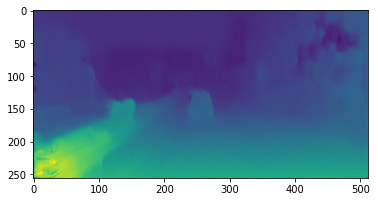

In [68]:
#net = torch.load("/eva_data/hylai_model/cs_lr_crop_model/model_epoch10", map_location={'cuda:2':'cuda:1'})
#net = torch.load("/eva_data/hylai_model/new_lr_grad_model/model_epoch45")
disparities = np.zeros((697, 256, 512), dtype=np.float32)
disparities_pp = np.zeros((697, 256, 512), dtype=np.float32)
for batch_idx, (left, right) in enumerate(TestImageLoader, 0):
    print(batch_idx)
    #plt.imshow(np.flip(right.numpy()[0,0,:,:], 1))
    #model_input = Variable(torch.cat((right, left), 1).cuda())
    left_batch = torch.cat((left, torch.from_numpy(np.flip(left.numpy(), 3).copy())), 0)
    right_batch = torch.cat((right, torch.from_numpy(np.flip(right.numpy(), 3).copy())), 0)
    model_input = Variable(torch.cat((left_batch, right_batch), 1).cuda())
    #model_input = Variable(left.cuda())
    disp_est_scale, disp_est = net(model_input)
    disparities[batch_idx] = -disp_est[0][0,0,:,:].data.cpu().numpy()
    #print(disp_est_scale[0][1,0,:,:])
    plt.imshow(-disp_est_scale[0][0,0,:,:].data.cpu().numpy())
    disp_pp = post_process_disparity(disp_est[0][:,0,:,:].data.cpu().numpy())
    disparities_pp[batch_idx] = disp_pp
    #disp_to_img = scipy.misc.imresize(disp_pp, [375, 1242])
    #print(disp_pp)
    #plt.imshow(disp_pp)
    break
#np.save('/home/hylai/monodepth/disparities.npy', disparities)
#np.save('/home/hylai/monodepth/disparities_pp.npy', disparities_pp)

In [ ]:
1. KITTI flow dataset is too small(200 pairs), CityScapes on request
2. flow loss function, some of pixels are 0, learning rate
3. left-right consistency

In [67]:
#test
import scipy.misc

input_image = scipy.misc.imread("./test.jpg", mode="RGB")
original_height, original_width, num_channels = input_image.shape
input_image = scipy.misc.imresize(input_image, [256, 512], interp='lanczos')
input_image = input_image.astype(np.float32) / 255
input_images = np.stack((input_image, np.fliplr(input_image)), 0)
model_input = Variable(torch.from_numpy(input_images.transpose((0,3,1,2))).cuda())
disp_est = net(model_input)

disp_pp = post_process_disparity(disp_est[0][:,0,:,:].data.cpu().numpy())
disp_to_img = scipy.misc.imresize(disp_pp, [original_height, original_width])
plt.imshow(disp_to_img)
plt.imsave("./myresult.png", disp_to_img, cmap='plasma')
#torch.save(net, "./model_city2kitti")
print(disp_to_img)

/home/hylai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/hylai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


RuntimeError: Given groups=1, weight[64, 6, 7, 7], so expected input[2, 3, 256, 512] to have 6 channels, but got 3 channels instead